<a href="https://colab.research.google.com/github/aharriechen/hello-world/blob/master/ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prices Prediction in Machine Learning Techniques

ID：13059276

**Introduction**

Machine learning plays a huge role in financial institutions because they can predict time series data with high precision to obtain money. For example, predict the trend of stock prices. In fact, predicting how the stock market will change is difficult. This forecasting behavior can be influenced by many factors —— including financial fundamentals or psychological factors. All these factors combine to make stock prices volatile and difficult to predict accurately. So engineers continue to work on the model, hoping to make it more accurate.

In this paper, we will study the historical data of stock prices of listed companies. We will combine machine learning algorithms to predict the company's future stock price.

**Methodology**

**1. Identify the problem.**

Stock analysis is judged from two aspects -- fundamentals and technical aspects.

Fundamental analysis represents a prediction of the company's future profitability based on its current financial position.

Technical analysis analyze charts to determine the future trend of stocks.

The emphasis in this paper will be on the technical analysis section. 

**2. Selected data**

The data I selected was OMX Stockholm Consumer Services GI (SX5000GI). The source is free data from Quandl.

The time is from January 3, 2016 to September 20, 2019.

source: [SX5000GI](https://www.quandl.com/data/NASDAQOMX/SX5000GI-OMX-Stockholm-Consumer-Services-GI-SX5000GI/)

**Step:**

In [48]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'17CQjr0eD3jSFhOueXAg9eoYQKkTCcTQ8'}) 

downloaded.GetContentFile('train.csv')  

#3. Read file as panda dataframe
import pandas as pd
xyz = pd.read_csv('train.csv') 

W0926 05:24:05.938838 140131171420032 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    'file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth')
ImportError: file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth


In [193]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline


from datetime import date
from matplotlib import pyplot as plt
from matplotlib import style
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from IPython.display import SVG
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


df = pd.read_csv('train.csv')


df.head()

,Trade Date,Index Value,High,Low,Total Market Value,Dividend Market Value
0,2019-09-20,1577.64,1582.87,1573.26,5.789004e+11,0.0
1,2019-09-19,1576.38,1577.63,1566.48,5.784360e+11,0.0
2,2019-09-18,1571.55,1573.76,1560.90,5.766653e+11,0.0
3,2019-09-17,1563.12,1568.62,1549.63,5.735722e+11,0.0
4,2019-09-16,1553.87,1564.41,1542.04,5.701780e+11,0.0


There are several variables in the table—— data,index value, high, low, total market value and dividend market value.

The **High** and the **Low** represent the highest and lowest stock prices of the day。

The **Index Value** represents the closing price of a stock index.

**Market Value** refers to the price of an asset in the trading market, which is the price that both buyers and sellers can accept after bidding.





In [0]:
style.use('ggplot')

Text(0,0.5,'dollar')

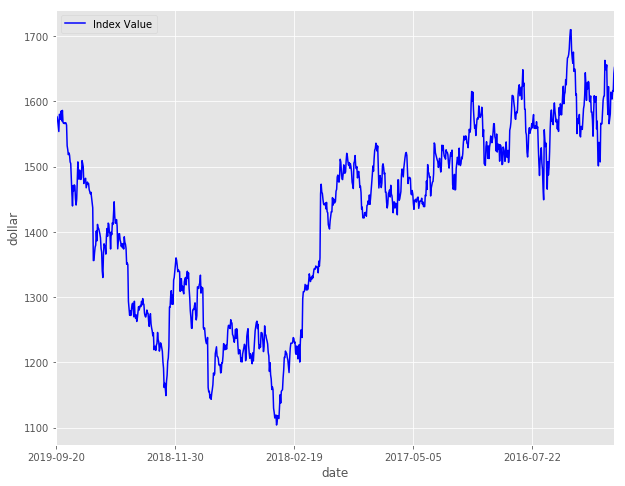

In [195]:
rcParams['figure.figsize'] = 10, 8 

ax = df.plot(x='Trade Date', y='Index Value', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("dollar")

In fact, some data is missing from the chart. The date is missing because the stock market does not work during the holiday, so some data is  not generated.

**The data set is divided into training set, verification set and test set.**

In [196]:
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

num_train = 565
num_cv = 187
num_test = 187


**Cut the data set, leaving only the date and Index value**

In [197]:
train = df[:num_train][['Trade Date', 'Index Value']]
cv = df[num_train:num_train+num_cv][['Trade Date', 'Index Value']]
train_cv = df[:num_train+num_cv][['Trade Date', 'Index Value']]
test = df[num_train+num_cv:][['Trade Date', 'Index Value']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (565, 2)
cv.shape = (187, 2)
train_cv.shape = (752, 2)
test.shape = (187, 2)


**The training set**

In [198]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['Index Value']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

scaler.mean_ = [1338.03930973]
scaler.var_ = [14205.01372147]
x_train_scaled.shape = (556, 9, 1)
y_train_scaled.shape = (556, 1)


**The validation set**

In [199]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['Index Value']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (187, 9, 1)
y_cv.shape = (187, 1)
len(mu_cv_list) = 187
len(std_cv_list) = 187


**Training and verification**

In [200]:

scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['Index Value']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['Index Value]).reshape(-1,1), N, num_train+num_cv)
# print("x_test_scaled.shape = " + str(x_test_scaled.shape))
# print("y_test.shape = " + str(y_test.shape))
# print("len(mu_test_list) = " + str(len(mu_test_list)))
# print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [1379.99390957]
scaler_final.var_ = [16447.37860785]


***Moving average technique***

I will use the moving average technique to predict the latest values for each group. For each subsequent step, remove the earliest observed value from the set and predict the value. The moving average model focuses on the accumulation of error terms in the autoregressive model.

Root-mean-square deviation(RMSE) and mean absolute percentage error (MAPE) are the regression evaluation index. The value is smaller, the fitting effect is the better.

![替代文字](https://i1.wp.com/s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/10/stock8.png?resize=724%2C270&ssl=1)

In [232]:

y_cv_pred_scaled = model.predict(x_cv_scaled)
y_cv_pred = (y_cv_pred_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("y_cv_pred.shape = " + str(y_cv_pred.shape))

rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, y_cv_pred))
print("RMSE = %0.3f" % rmse_bef_tuning)

mape_pct_bef_tuning = get_mape(y_cv, y_cv_pred)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

y_cv_pred.shape = (187, 1)
RMSE = 20.938
MAPE = 1.043%




The RMSE value is large, the results might be not as good as expected. 

Next, I'll show you another way.

***Long Short-Term Memory***

LSTM algorithm（LSTM） is widely used in sequence prediction. It proved to be an effective method. LSTM can store important past information and ignore unimportant information.
LSTM is divided into three stages: forget, select memory and output. It is mainly responsible for solving the problems of gradient disappearance and gradient explosion during long sequence training.


![替代文字](https://miro.medium.com/max/542/1*ULozye1lfd-dS9RSwndZdw.png)

In [201]:
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) 
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

model.summary()

Epoch 1/1
 - 34s - loss: 0.0758
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_137 (LSTM)              (None, 9, 50)             10400     
_________________________________________________________________
dropout_137 (Dropout)        (None, 9, 50)             0         
_________________________________________________________________
lstm_138 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_138 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


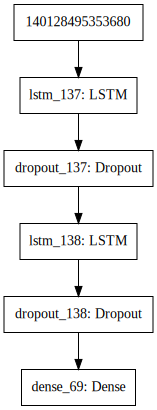

In [202]:
plot_model(model, to_file='model_lstm.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

**Prediction on the validation set**

Text(0,0.5,'dollar')

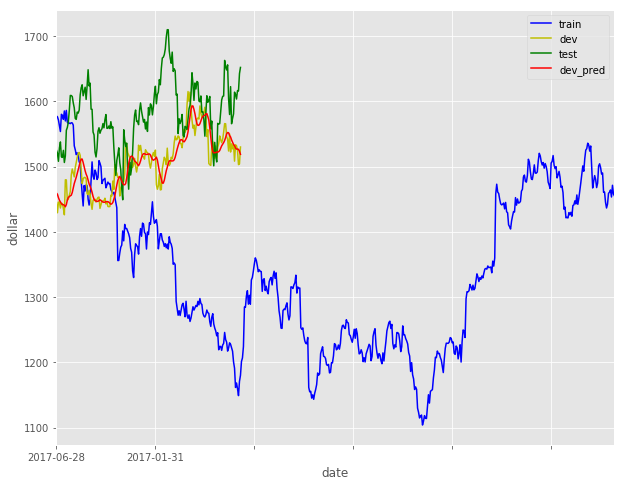

In [101]:
rcParams['figure.figsize'] = 10, 8 

pred_df = pd.DataFrame({'y_cv_pred': y_cv_pred.reshape(-1),   
                        'y_cv': y_cv.reshape(-1),
                        'date': cv['Trade Date']})

ax = train.plot(x='Trade Date', y='Index Value', style='b-', grid=True)
ax = cv.plot(x='Trade Date', y='Index Value', style='y-', grid=True, ax=ax)
ax = test.plot(x='Trade Date', y='Index Value', style='g-', grid=True, ax=ax)
ax = pred_df.plot(x='date', y='y_cv_pred', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'dev_pred'])
ax.set_xlabel("date")
ax.set_ylabel("dollar")

The value of RMSE is relatively large, and the fitting effect is general.

**Tuning N (no. of days to use as features)**

In [0]:
param_label = 'N'
param_list = range(3, 40)

**Note：The code takes more than 15 minutes to run. Be patient.**

In [132]:


error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['Index Value']).reshape(-1,1), param, num_train)
    
    rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                          y_train_scaled,
                                          x_cv_scaled,
                                          y_cv,
                                          mu_cv_list,
                                          std_cv_list,
                                          lstm_units=lstm_units,
                                          dropout_prob=dropout_prob,
                                          optimizer=optimizer,
                                          epochs=epochs,
                                          batch_size=batch_size)
    
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 15.6580983996


,N,mape_pct,rmse
0,3,0.971713,19.049398
1,4,0.994379,19.940760
2,5,1.002452,20.101202
3,6,1.044864,20.968531
4,7,1.032487,20.752794
5,8,1.038409,20.853097
6,9,1.038833,20.884153
7,10,0.999545,20.124911
8,11,0.980980,19.804531
9,12,1.016030,20.433847


**Error curve**

Text(0,0.5,'RMSE/MAPE(%)')

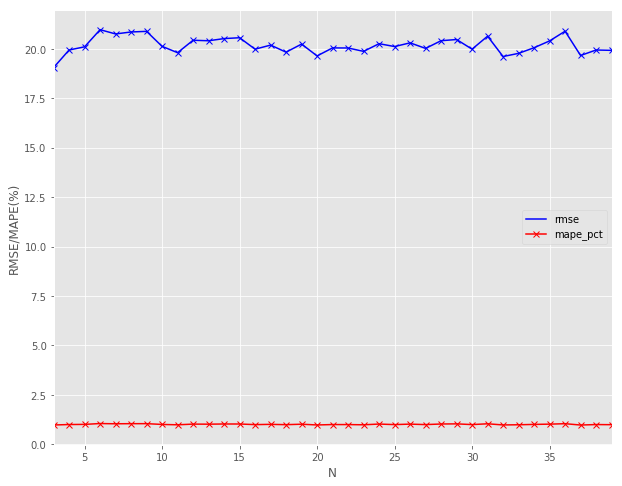

In [133]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [134]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]

print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 19.049
min MAPE = 0.969%
optimum N = 3


3 days is the best fitting time.

In [147]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]


x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)


x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['Index Value']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()

for param in tqdm_notebook(param_list):
    for param2 in tqdm_notebook(param2_list):
      
        rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                              y_train_scaled,
                                              x_cv_scaled,
                                              y_cv,
                                              mu_cv_list,
                                              std_cv_list,
                                              lstm_units=lstm_units,
                                              dropout_prob=dropout_prob,
                                              optimizer=optimizer,
                                              epochs=param,
                                              batch_size=param2)
       
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 14.744626534


,batch_size,epochs,mape_pct,rmse
0,8,1,0.994238,19.455000
1,16,1,0.983285,19.249408
2,32,1,0.895403,17.675562
3,64,1,0.879053,17.402731
4,128,1,0.874689,17.326135
5,8,10,0.929222,18.297933
6,16,10,0.975167,19.113916
7,32,10,0.983203,19.255031
8,64,10,1.001084,19.581870
9,128,10,1.020591,19.944718


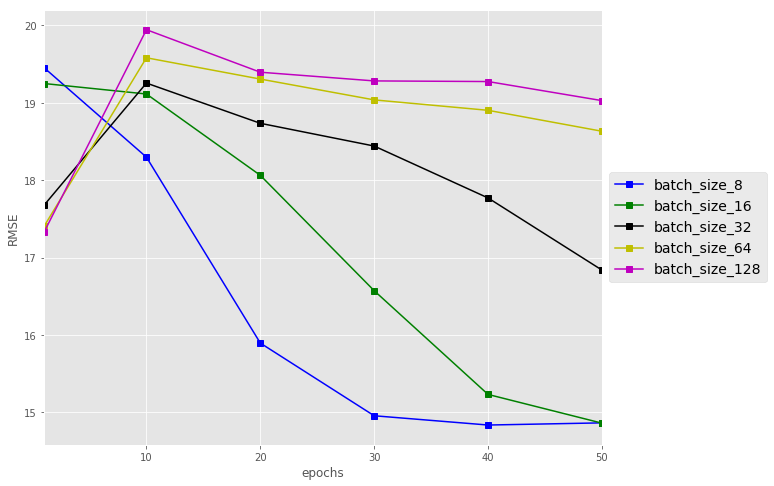

In [231]:
rcParams['figure.figsize'] = 10, 8 
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) 

**Evaluation**


In fact, I think there is something wrong with the algorithm design of LSTM. It has three problems. First, the model has the possibility of garbage in garbage out. Second, it is very likely to overfit. Third, it is based on past data to predict the future. Yet what has affected share prices in the past is likely to be different from what will happen in the future.

To test this model, I used the stocks selected by the model to experiment on the simulation board for several weeks. 

Result: losses cannot cover profits.

The results is far from ideal. Obviously, this model cannot be applied to daily investment transactions. 

Note: blue represents losses and red represents profits.


(<a href="https://sm.ms/image/5acGiZ7YfkITrpv" target="_blank"><img src="https://i.loli.net/2019/09/26/5acGiZ7YfkITrpv.png" ></a>)

In my opinion, deep learning is an induction method based on historical data for fitting. If deep learning is used for stock prediction, it is expected to lose money in the long term, because the market is changing and the rules are changing,  the result may not be satisfactory.

For the LSTM model, the prediction data it USES is not the previous training data rather than  the verification data, which is equivalent to self-prediction, and the reliability of the result decrases. I hope this problem will be solved in the future.

LSTM can adjust various parameters in the model. It can also change the number of LSTM layers, add discarded values or increase the number of subgenerations. It is easier to understand than the MA model.

**Conclusion**

The MA model and the LSTM model have many advantages. However, there are still many limitations.

One should not be fooled by articles that forecast curves completely overlap with real stock prices. That's just a simple average technique to replicate. In fact, it doesn't work.

Forecasting stock prices is an extremely difficult task. I don't think any stock forecasting model should be relied on blindly. Of course, models may correctly predict stock price movements in most cases.



**References**

https://www.jianshu.com/p/c019426e041d
https://github.com/fastai/fastai
https://36kr.com/p/5126349